In [71]:
import numpy as np
import matplotlib.pyplot as plt 

import importlib

import components as comp
importlib.reload(comp);

In [72]:
### Parameters
computational_states    = 3
resonator_states        = 15


# Readout duration
duration = (0, 50)

# Define the components, which are defined in components.py

# The superconducting qubit
transmon = comp.Transmon(
    n_cutoff        = 11,
    e               = 1.519e6,              # GHz / V
    EJ              = 34,                   # GHz hbar
    EJ_EC_ratio     = 128,                  # Gives EC = EJ / ratio
    # gamma           = 2.5                 # EJ2 / EJ1    
)

# Resonator for readout
resonator = comp.Resonator(
    omega           = 6.02,                 # GHz
    n_cutoff        = resonator_states      # States of harmonic oscillator
    
)

# Readout pulse
readout_pulse = comp.GaussianPulseGenerator(
    T       = 25,              # Center of envelope
    width   = 3,              # Width of envelope
    omega   = 6.02,             # Frequency
    phase   = 0,                # Phase
    drag    = False
)


In [73]:
# Mathematical tools:

# Define a function to take the partial trace of the density matrix
def partial_trace(density_matrix, trace_over = 0, dims = (resonator_states, computational_states)):
    
    # Partial trace over the resonator
    decomposite = np.array(density_matrix).reshape(dims[0], dims[1], dims[0], dims[1])   
    partial_trace = np.trace(decomposite, axis1 = trace_over, axis2 = trace_over + 2)
    return partial_trace

## Defining Hamiltonians
We can now define the hamiltonians of the system:

In [74]:
# Find subspace of Transmon
Es, Psis = transmon.eigen_basis(computational_states)   # Get states and energies for transmon
H0_transmon = np.diag(Es - Es[0])                       # Set E0 = 0


# H0 of the resonator is simply found by:
H0_resonator    = resonator.Hamiltonian().todense()


# We need to define mathematical tools to combine the system
transmon_identity   = np.identity(n = computational_states)
resonator_identity  = np.identity(n = resonator_states)

# Combine the Hamiltonians by tensor product 
H0_transmon_big  = np.kron(resonator_identity,  H0_transmon)
H0_resonator_big = np.kron(H0_resonator,        transmon_identity)

# Sum to get full H0 in 3 x 20 space
H0 = H0_transmon_big + H0_resonator_big


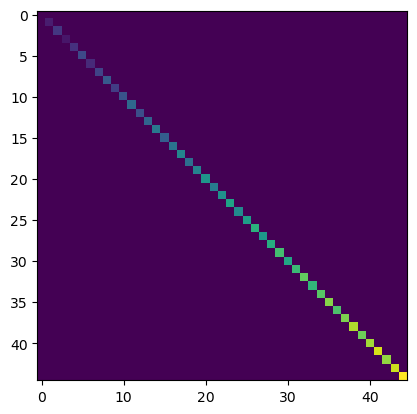

In [75]:
plt.imshow(H0)

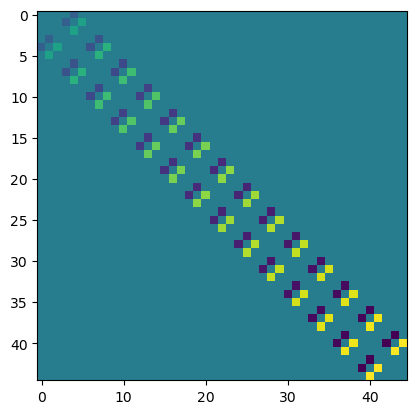

In [76]:
# Transmon interaction
H_overlap_n = np.conjugate(Psis).T @ transmon.n_matrix() @ Psis

#### NEED MORE THEORY TO DEFINE THIS INTERACTION TERM #### 
# Now we just assume g_k = 1. Probably we take the overlap between them.
H_int_resonator = (resonator.a_dagger() + resonator.a()).todense()

# Direct product to get it in 3 x 20 hilbert space
H_int = np.kron(H_int_resonator, H_overlap_n)


plt.imshow(H_int)

## Interaction Eigenvalues 

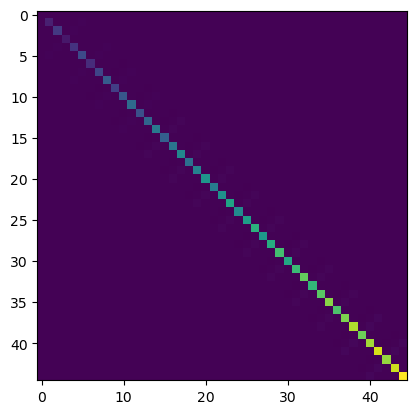

In [77]:
interaction_strength = 0.130 # GHz 

H = H0 + interaction_strength *  H_int
plt.imshow(H)

In [78]:
Es, U = np.linalg.eigh(H)

In [79]:
# # Find energy of the ground state of the transmon. 
# transmon_g = np.array((1, 0, 0))
# resonator_g = np.zeros(resonator_states)
# resonator_g[5] += 1

# ground_state = np.kron(resonator_g, transmon_g)
# density_matrix = np.outer(ground_state, ground_state.conj())

## Readout Drive

In [80]:
from numba import jit

In [81]:
pulse_on_resonator = readout_pulse.output()

# Define the time dependent Hamiltonian to drive the resonator
@jit()
def H_resonator_drive(t):
    total_pulse = pulse_on_resonator[0](t) + pulse_on_resonator[1](t) 
    H_reso = 2j *  total_pulse * (resonator.a_dagger() - resonator.a())

    H_reso_hilbert_space = np.kron(H_reso.todense(), transmon_identity)

    return H_reso_hilbert_space


In [82]:
def total_hamiltonian(t):
    return H + H_resonator_drive(t)

dimensions = (resonator_states * computational_states, resonator_states * computational_states)

# Define the master equation
@jit()
def master_equation(t, y):
    density_matrix = y.reshape(dimensions)

    # Calculate the time dependent hamiltonian
    H_t = total_hamiltonian(t)
    
    # Calculate the time derivative of the density matrix
    d_rho = -1j * (H_t @ density_matrix - density_matrix @ H_t.conj().T)
    
    return d_rho.flatten()

# Define the first excited state of the resonator
resonator_e = np.zeros(resonator_states, dtype = np.complex128)
resonator_e[5] = 1

# Define ground state of transmon
transmon_g = np.array((1, 0, 0), dtype = np.complex128)

# Define initial density matrix
initial_state = np.kron(resonator_e, transmon_g)
initial_density_matrix = np.outer(initial_state, initial_state.conj())


# Solve the master equation
from scipy.integrate import solve_ivp

results = solve_ivp(master_equation, duration, initial_density_matrix.flatten())


/tmp/ipykernel_4064/716749793.py:7: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "master_equation" failed type inference due to: Untyped global name 'total_hamiltonian': Cannot determine Numba type of <class 'function'>

File "../../../../../../../../../tmp/ipykernel_4064/716749793.py", line 12:
<source missing, REPL/exec in use?>

  @jit()
/home/johannseverin/anaconda3/envs/qi/lib/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "master_equation" was compiled in object mode without forceobj=True.

File "../../../../../../../../../tmp/ipykernel_4064/716749793.py", line 7:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/johannseverin/anaconda3/envs/qi/lib/python3.9/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecate

In [83]:
# final_state = results.y[..., -1].reshape(45, 45)
# S11 = [initial_state.conj().T @ results.y[...,i].reshape(15, 15) @ initial_state for i in range(len(results.t))]

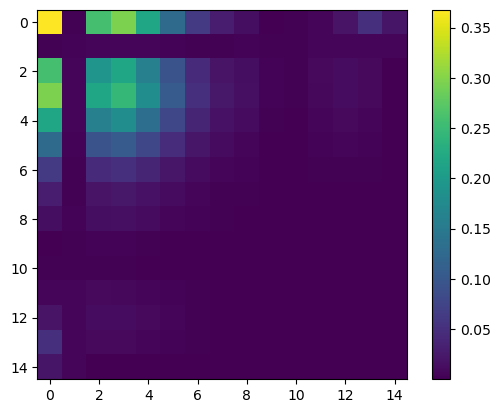

In [84]:
plt.imshow(abs(partial_trace(final_state, trace_over = 1, dims = (resonator_states, computational_states))))
plt.colorbar()

In [85]:
density_matrices = [results.y[:, i].reshape(45, 45) for i in range(len(results.t))]
density_matrices_resonator = [partial_trace(density_matrix, trace_over = 1, dims = (resonator_states, computational_states)) for density_matrix in density_matrices]
density_matrices_resonator = np.array(density_matrices_resonator)

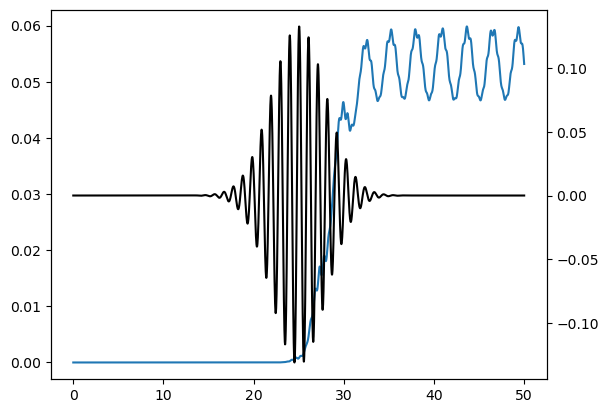

In [86]:
fig, ax = plt.subplots()
ax.plot(results.t, np.real(density_matrices_resonator[:, 1, 1]))
# plt.plot(results.t, np.imag(S11))

ax1 = ax.twinx()
ax1.plot(results.t, pulse_on_resonator[0](results.t) + pulse_on_resonator[1](results.t) , color = 'black')

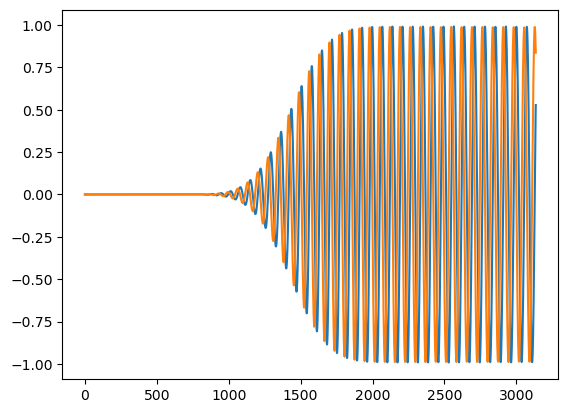

In [87]:
lowering_operator = np.kron(resonator.a().todense(), transmon_identity)
reaising_operator = np.kron(resonator.a_dagger().todense(), transmon_identity)

# Calculate the expectation value of the lowering operator as a function of time
expectation_values = np.array([np.trace(density_matrix @ lowering_operator) for density_matrix in density_matrices])

plt.plot(expectation_values.real)
plt.plot(expectation_values.imag)

In [88]:
from numpy.fft import fft
fourier_transformed = fft(expectation_values)
fourier_transformed[np.argmax(abs(fourier_transformed))]

(1527.4845888215305+438.94577829528424j)